In [4]:
%matplotlib notebook

import numpy as np
import json
import math
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from numpy.random import seed 
seed(2)
tf.random.set_seed(9)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU,Dense, Dropout, Flatten, Input, BatchNormalization, Reshape, UpSampling1D, Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import regularizers

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,Binarizer

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score,f1_score

In [ ]:
fp_list = ['maccs']

class Data():
    
    def __init__(self, fp, pos_neg):
        
        self.fp = fp
        self.pos_neg = pos_neg
        
        if self.pos_neg == 'pos':
            self.load_pos_data()
            self.shuffle()
            
        elif self.pos_neg == 'neg':
            self.load_neg_data()
            self.shuffle()
    

    def load_pos_data(self):
        with open('{}.json'.format(self.fp), 'r') as file:
            temp = json.load(file)
        positive_index = [i for i in range(len(temp['y'])) if temp['y'][i] == [1,0]]
        self.y = np.array([temp['y'][i] for i in positive_index])
        self.x = np.array([self.convert(temp['x'][i]) for i in positive_index])
        self.x = self.x.reshape(self.x.shape[0], self.x.shape[1],1)
        self.z = self.x.reshape(self.x.shape[0], self.x.shape[1])
        self.m = len(positive_index)
        self.n = self.x.shape[1]
        print('Shape x: {}'.format(self.x.shape))
        print('Shape y: {}'.format(self.y.shape))
    
    def load_neg_data(self):
        with open('{}.json'.format(self.fp), 'r') as file:
            temp = json.load(file)
        negative_index = [i for i in range(len(temp['y'])) if temp['y'][i] == [0,1]]
        self.y = np.array([temp['y'][i] for i in negative_index])
        self.x = np.array([self.convert(temp['x'][i]) for i in negative_index])
        self.x = self.x.reshape(self.x.shape[0], self.x.shape[1],1)
        self.z = self.x.reshape(self.x.shape[0], self.x.shape[1])
        self.m = len(negative_index)
        self.n = self.x.shape[1]
        print('Shape x: {}'.format(self.x.shape))
        print('Shape y: {}'.format(self.y.shape))
    
    def shuffle(self):
        temp_x = np.zeros(self.x.shape)
        index = list(range(self.m))
        np.random.shuffle(index)
        for x in range(self.m):
            value = int(index[int(x)])
            temp_x[x,:] = self.x[value,:]
        self.x = temp_x
                                  
    def convert(self, string, as_array=True):
        letter_list = list('abcdef')
        jump = 1
        fp = []
        code = [0]*len(list(string))*4
        for index in range(len(list(string))):
            index += jump
            value = string[index].lower()
            if value in letter_list:
                value = letter_list.index(value) + 10
            index = (index-jump)*4
            value = int(value)
            code[index] = 1*value%2
            code[index+1] = 1*math.floor(value/2)%2
            code[index+2] = 1*math.floor(value/4)%2
            code[index+3] = 1*math.floor(value/8)%2
            jump *= -1
        if as_array == True:
            code = np.array(code)
        return code

In [6]:
pos_data=Data(fp='maccs', pos_neg='pos')
neg_data=Data(fp='maccs', pos_neg='neg')

Shape x: (7201, 168, 1)
Shape y: (7201, 2)
Shape x: (10000, 168, 1)
Shape y: (10000, 2)


In [7]:
batch_size=256
fingerprint_dim=168

#get real compounds
index = np.random.choice(range(pos_data.m), size=(batch_size), replace=False)
train_x_real = pos_data.x[index]
train_y_real = np.zeros([batch_size,2])
train_y_real[:,0] = 1
#d_loss_real = d.train_on_batch(train_x_real,train_y_real)
                
#get fake compounds
input_value = np.random.randint(0,2,size=[batch_size, fingerprint_dim])
train_x_fake = input_value.reshape((input_value.shape[0], input_value.shape[1], 1))
train_y_fake = np.zeros([batch_size,2])
train_y_fake[:,1] = 1
#d_loss_fake=d.train_on_batch(train_x_fake,train_y_fake)
        
#get decoys
index1 = np.random.choice(range(neg_data.m), size=(batch_size), replace=False)
train_x_decoy = neg_data.x[index1]
train_y_decoy = np.zeros([batch_size,2])
train_y_decoy[:,1] = 1
#d_loss_decoy = d.train_on_batch(train_x_real,train_y_real)
       
# d_loss = d_loss_real + d_loss_decoy
# loss_d_epoch.append(d_loss[0])
X = np.concatenate((train_x_real, train_x_decoy))
y = np.zeros([2*batch_size,2])
y[0:(batch_size),0] = 1
y[(batch_size):,1] = 1

In [8]:
y.shape

(512, 2)

In [9]:
epochs=1

model = Sequential()
model.add(Conv1D(6, kernel_size=5,
                 strides=4,
                 activation='relu',
                 padding='valid',
                 input_shape=[fingerprint_dim,1],
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(AveragePooling1D(pool_size=2, strides=1, padding='valid'))
model.add(Conv1D(16, kernel_size=5, activation= 'relu', strides=4, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(pool_size=2, strides=1, padding='valid'))

model.add(Conv1D(120, kernel_size=5, activation= 'relu', strides=4, padding='same'))
model.add(Flatten())

model.add(Dense(84, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0002),
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 41, 6)             36        
_________________________________________________________________
average_pooling1d (AveragePo (None, 40, 6)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 16)            496       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 16)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 120)            9720      
_________________________________________________________________
flatten (Flatten)            (None, 360)               0         
_________________________________________________________________
dense (Dense)                (None, 84)                3

In [10]:
model.fit(X, y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X, y))

2/2 [==============================] - 0s 130ms/step - loss: 2.1845 - accuracy: 0.5000 - val_loss: 2.1724 - val_accuracy: 0.5020


In [11]:
cv = StratifiedKFold(n_splits=10)

In [12]:
df_y = pd.DataFrame(y)

In [13]:
y_new = df_y.iloc[:,0]

In [15]:
mean_fpr = np.linspace(0, 1, 100)
tprs=[]
tprs_all=[]
fprs=[]
aucs=[]
accs=[]
f1s=[]
for train,test in cv.split(X,y_new):
    model.fit(X[train],y[train],
             batch_size=batch_size,
             epochs=50,
             verbose=1,
             validation_data=(X[test],y[test]))
    pred_prob = model.predict_proba(X[test])[:,0]
    pred = model.predict(X[test])[:,0]
    y_pred = np.round(pred)
    print(y_pred)
    print(pred_prob)
    fpr, tpr, thresholds = roc_curve(y_new[test],pred_prob)
    roc_auc = auc(fpr,tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs_all.append(interp_tpr)
    
    acc = accuracy_score(y_new[test], y_pred)
    f1 = f1_score(y_new[test], y_pred)
    accs.append(acc)
    f1s.append(f1)
    
    

Epoch 1/50
2/2 [==============================] - 0s 114ms/step - loss: 2.1690 - accuracy: 0.5022 - val_loss: 2.1566 - val_accuracy: 0.5000
Epoch 2/50
2/2 [==============================] - 0s 14ms/step - loss: 2.1533 - accuracy: 0.5022 - val_loss: 2.1412 - val_accuracy: 0.5000
Epoch 3/50
2/2 [==============================] - 0s 12ms/step - loss: 2.1379 - accuracy: 0.5022 - val_loss: 2.1259 - val_accuracy: 0.5000
Epoch 4/50
2/2 [==============================] - 0s 11ms/step - loss: 2.1225 - accuracy: 0.5065 - val_loss: 2.1109 - val_accuracy: 0.5192
Epoch 5/50
2/2 [==============================] - 0s 12ms/step - loss: 2.1074 - accuracy: 0.5130 - val_loss: 2.0961 - val_accuracy: 0.5385
Epoch 6/50
2/2 [==============================] - 0s 11ms/step - loss: 2.0925 - accuracy: 0.5152 - val_loss: 2.0815 - val_accuracy: 0.5577
Epoch 7/50
2/2 [==============================] - 0s 13ms/step - loss: 2.0777 - accuracy: 0.5261 - val_loss: 2.0670 - val_accuracy: 0.5769
Epoch 8/50
2/2 [==========

2/2 [==============================] - 0s 16ms/step - loss: 1.5175 - accuracy: 0.7109 - val_loss: 1.4886 - val_accuracy: 0.8077
Epoch 3/50
2/2 [==============================] - 0s 13ms/step - loss: 1.5069 - accuracy: 0.7109 - val_loss: 1.4772 - val_accuracy: 0.8077
Epoch 4/50
2/2 [==============================] - 0s 15ms/step - loss: 1.4961 - accuracy: 0.7109 - val_loss: 1.4661 - val_accuracy: 0.8077
Epoch 5/50
2/2 [==============================] - 0s 13ms/step - loss: 1.4852 - accuracy: 0.7152 - val_loss: 1.4549 - val_accuracy: 0.8077
Epoch 6/50
2/2 [==============================] - 0s 13ms/step - loss: 1.4745 - accuracy: 0.7174 - val_loss: 1.4439 - val_accuracy: 0.8077
Epoch 7/50
2/2 [==============================] - 0s 12ms/step - loss: 1.4639 - accuracy: 0.7174 - val_loss: 1.4332 - val_accuracy: 0.8077
Epoch 8/50
2/2 [==============================] - 0s 13ms/step - loss: 1.4535 - accuracy: 0.7196 - val_loss: 1.4227 - val_accuracy: 0.8077
Epoch 9/50
2/2 [======================

2/2 [==============================] - 0s 13ms/step - loss: 1.0680 - accuracy: 0.7397 - val_loss: 0.9902 - val_accuracy: 0.8235
Epoch 6/50
2/2 [==============================] - 0s 12ms/step - loss: 1.0617 - accuracy: 0.7397 - val_loss: 0.9847 - val_accuracy: 0.8431
Epoch 7/50
2/2 [==============================] - 0s 12ms/step - loss: 1.0556 - accuracy: 0.7440 - val_loss: 0.9792 - val_accuracy: 0.8431
Epoch 8/50
2/2 [==============================] - 0s 12ms/step - loss: 1.0493 - accuracy: 0.7462 - val_loss: 0.9734 - val_accuracy: 0.8235
Epoch 9/50
2/2 [==============================] - 0s 12ms/step - loss: 1.0432 - accuracy: 0.7419 - val_loss: 0.9681 - val_accuracy: 0.8431
Epoch 10/50
2/2 [==============================] - 0s 12ms/step - loss: 1.0370 - accuracy: 0.7505 - val_loss: 0.9631 - val_accuracy: 0.8431
Epoch 11/50
2/2 [==============================] - 0s 13ms/step - loss: 1.0312 - accuracy: 0.7592 - val_loss: 0.9585 - val_accuracy: 0.8431
Epoch 12/50
2/2 [===================

2/2 [==============================] - 0s 12ms/step - loss: 0.7861 - accuracy: 0.8178 - val_loss: 0.9167 - val_accuracy: 0.7255
Epoch 9/50
2/2 [==============================] - 0s 12ms/step - loss: 0.7822 - accuracy: 0.8156 - val_loss: 0.9115 - val_accuracy: 0.7255
Epoch 10/50
2/2 [==============================] - 0s 13ms/step - loss: 0.7779 - accuracy: 0.8243 - val_loss: 0.9065 - val_accuracy: 0.7451
Epoch 11/50
2/2 [==============================] - 0s 12ms/step - loss: 0.7743 - accuracy: 0.8286 - val_loss: 0.9012 - val_accuracy: 0.7647
Epoch 12/50
2/2 [==============================] - 0s 12ms/step - loss: 0.7701 - accuracy: 0.8286 - val_loss: 0.9021 - val_accuracy: 0.7451
Epoch 13/50
2/2 [==============================] - 0s 13ms/step - loss: 0.7660 - accuracy: 0.8286 - val_loss: 0.9068 - val_accuracy: 0.7255
Epoch 14/50
2/2 [==============================] - 0s 12ms/step - loss: 0.7624 - accuracy: 0.8200 - val_loss: 0.9028 - val_accuracy: 0.7255
Epoch 15/50
2/2 [================

2/2 [==============================] - 0s 12ms/step - loss: 0.6398 - accuracy: 0.8416 - val_loss: 0.5860 - val_accuracy: 0.8824
Epoch 12/50
2/2 [==============================] - 0s 12ms/step - loss: 0.6377 - accuracy: 0.8416 - val_loss: 0.5859 - val_accuracy: 0.8824
Epoch 13/50
2/2 [==============================] - 0s 12ms/step - loss: 0.6343 - accuracy: 0.8460 - val_loss: 0.5848 - val_accuracy: 0.8627
Epoch 14/50
2/2 [==============================] - 0s 12ms/step - loss: 0.6320 - accuracy: 0.8438 - val_loss: 0.5841 - val_accuracy: 0.8627
Epoch 15/50
2/2 [==============================] - 0s 14ms/step - loss: 0.6295 - accuracy: 0.8438 - val_loss: 0.5833 - val_accuracy: 0.8627
Epoch 16/50
2/2 [==============================] - 0s 13ms/step - loss: 0.6271 - accuracy: 0.8482 - val_loss: 0.5832 - val_accuracy: 0.8824
Epoch 17/50
2/2 [==============================] - 0s 12ms/step - loss: 0.6247 - accuracy: 0.8590 - val_loss: 0.5823 - val_accuracy: 0.8627
Epoch 18/50
2/2 [===============

2/2 [==============================] - 0s 12ms/step - loss: 0.5280 - accuracy: 0.8807 - val_loss: 0.5936 - val_accuracy: 0.8039
Epoch 15/50
2/2 [==============================] - 0s 12ms/step - loss: 0.5263 - accuracy: 0.8850 - val_loss: 0.5931 - val_accuracy: 0.7843
Epoch 16/50
2/2 [==============================] - 0s 12ms/step - loss: 0.5246 - accuracy: 0.8850 - val_loss: 0.5920 - val_accuracy: 0.8039
Epoch 17/50
2/2 [==============================] - 0s 12ms/step - loss: 0.5229 - accuracy: 0.8807 - val_loss: 0.5926 - val_accuracy: 0.7843
Epoch 18/50
2/2 [==============================] - 0s 12ms/step - loss: 0.5210 - accuracy: 0.8807 - val_loss: 0.5936 - val_accuracy: 0.7843
Epoch 19/50
2/2 [==============================] - 0s 11ms/step - loss: 0.5202 - accuracy: 0.8872 - val_loss: 0.5944 - val_accuracy: 0.7843
Epoch 20/50
2/2 [==============================] - 0s 10ms/step - loss: 0.5179 - accuracy: 0.8807 - val_loss: 0.5935 - val_accuracy: 0.7843
Epoch 21/50
2/2 [===============

2/2 [==============================] - 0s 12ms/step - loss: 0.4815 - accuracy: 0.8807 - val_loss: 0.3971 - val_accuracy: 0.9608
Epoch 18/50
2/2 [==============================] - 0s 12ms/step - loss: 0.4805 - accuracy: 0.8829 - val_loss: 0.3983 - val_accuracy: 0.9608
Epoch 19/50
2/2 [==============================] - 0s 12ms/step - loss: 0.4798 - accuracy: 0.8894 - val_loss: 0.3990 - val_accuracy: 0.9608
Epoch 20/50
2/2 [==============================] - 0s 11ms/step - loss: 0.4784 - accuracy: 0.8894 - val_loss: 0.3973 - val_accuracy: 0.9608
Epoch 21/50
2/2 [==============================] - 0s 11ms/step - loss: 0.4774 - accuracy: 0.8829 - val_loss: 0.3967 - val_accuracy: 0.9608
Epoch 22/50
2/2 [==============================] - 0s 11ms/step - loss: 0.4769 - accuracy: 0.8829 - val_loss: 0.3965 - val_accuracy: 0.9608
Epoch 23/50
2/2 [==============================] - 0s 11ms/step - loss: 0.4756 - accuracy: 0.8829 - val_loss: 0.3969 - val_accuracy: 0.9608
Epoch 24/50
2/2 [===============

2/2 [==============================] - 0s 13ms/step - loss: 0.4327 - accuracy: 0.9024 - val_loss: 0.4310 - val_accuracy: 0.9216
Epoch 21/50
2/2 [==============================] - 0s 13ms/step - loss: 0.4325 - accuracy: 0.9024 - val_loss: 0.4298 - val_accuracy: 0.9216
Epoch 22/50
2/2 [==============================] - 0s 12ms/step - loss: 0.4317 - accuracy: 0.9024 - val_loss: 0.4269 - val_accuracy: 0.9216
Epoch 23/50
2/2 [==============================] - 0s 11ms/step - loss: 0.4306 - accuracy: 0.9002 - val_loss: 0.4273 - val_accuracy: 0.9216
Epoch 24/50
2/2 [==============================] - 0s 10ms/step - loss: 0.4298 - accuracy: 0.9002 - val_loss: 0.4271 - val_accuracy: 0.9216
Epoch 25/50
2/2 [==============================] - 0s 13ms/step - loss: 0.4293 - accuracy: 0.9024 - val_loss: 0.4270 - val_accuracy: 0.9216
Epoch 26/50
2/2 [==============================] - 0s 12ms/step - loss: 0.4284 - accuracy: 0.9002 - val_loss: 0.4297 - val_accuracy: 0.9216
Epoch 27/50
2/2 [===============

2/2 [==============================] - 0s 12ms/step - loss: 0.4008 - accuracy: 0.9089 - val_loss: 0.3980 - val_accuracy: 0.9216
Epoch 24/50
2/2 [==============================] - 0s 12ms/step - loss: 0.4003 - accuracy: 0.9132 - val_loss: 0.3987 - val_accuracy: 0.9216
Epoch 25/50
2/2 [==============================] - 0s 11ms/step - loss: 0.3998 - accuracy: 0.9111 - val_loss: 0.3990 - val_accuracy: 0.9020
Epoch 26/50
2/2 [==============================] - 0s 11ms/step - loss: 0.3990 - accuracy: 0.9089 - val_loss: 0.3995 - val_accuracy: 0.9020
Epoch 27/50
2/2 [==============================] - 0s 13ms/step - loss: 0.3984 - accuracy: 0.9132 - val_loss: 0.4003 - val_accuracy: 0.9020
Epoch 28/50
2/2 [==============================] - 0s 12ms/step - loss: 0.3979 - accuracy: 0.9132 - val_loss: 0.4009 - val_accuracy: 0.9020
Epoch 29/50
2/2 [==============================] - 0s 11ms/step - loss: 0.3976 - accuracy: 0.9132 - val_loss: 0.4013 - val_accuracy: 0.9020
Epoch 30/50
2/2 [===============

2/2 [==============================] - 0s 11ms/step - loss: 0.3756 - accuracy: 0.9262 - val_loss: 0.3752 - val_accuracy: 0.9020
Epoch 27/50
2/2 [==============================] - 0s 11ms/step - loss: 0.3751 - accuracy: 0.9306 - val_loss: 0.3764 - val_accuracy: 0.9020
Epoch 28/50
2/2 [==============================] - 0s 11ms/step - loss: 0.3751 - accuracy: 0.9284 - val_loss: 0.3757 - val_accuracy: 0.9020
Epoch 29/50
2/2 [==============================] - 0s 11ms/step - loss: 0.3742 - accuracy: 0.9262 - val_loss: 0.3770 - val_accuracy: 0.9020
Epoch 30/50
2/2 [==============================] - 0s 11ms/step - loss: 0.3737 - accuracy: 0.9371 - val_loss: 0.3793 - val_accuracy: 0.9020
Epoch 31/50
2/2 [==============================] - 0s 11ms/step - loss: 0.3737 - accuracy: 0.9414 - val_loss: 0.3781 - val_accuracy: 0.9020
Epoch 32/50
2/2 [==============================] - 0s 11ms/step - loss: 0.3732 - accuracy: 0.9262 - val_loss: 0.3767 - val_accuracy: 0.9020
Epoch 33/50
2/2 [===============

<IPython.core.display.Javascript object>


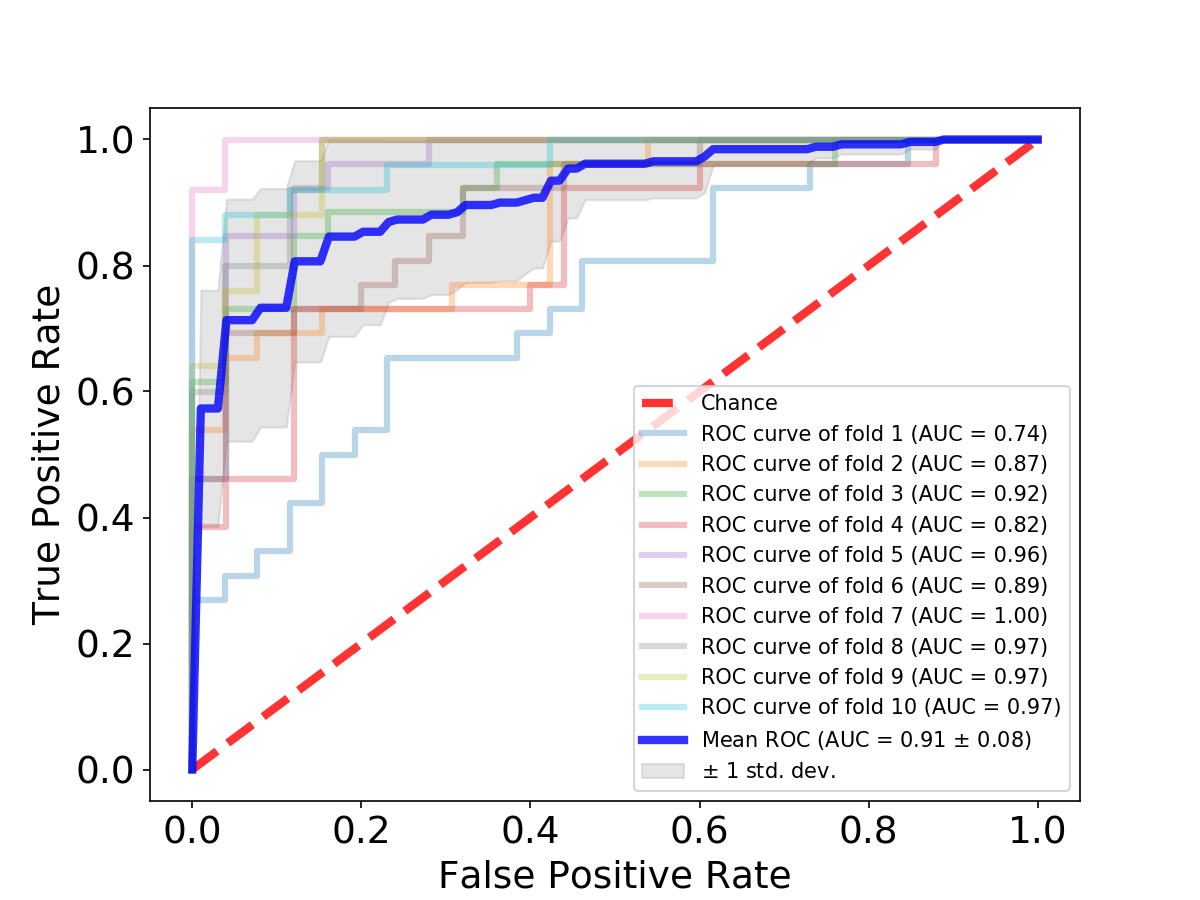

In [16]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot([0, 1], [0, 1], linestyle='--', color='r',
        label='Chance', alpha=.8, linewidth = 4)

for j in range(10):
    ax.plot(fprs[j], tprs[j], label='ROC curve of fold {0} (AUC = {1:0.2f})'.format(j+1, aucs[j]), alpha=0.3, linewidth = 3)

mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean(tprs_all, axis=0)
mean_tpr[-1] = 1.0
mean_auc_svm = auc(mean_fpr, mean_tpr)
std_auc_svm = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_svm, std_auc_svm),
        alpha=.8, linewidth = 4)

std_tpr = np.std(tprs_all, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])

ax.legend(loc="lower right")

plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend(loc="lower right", prop={"size":10})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('maccs_D_lenet5.pdf',dpi=600)
plt.show()